<!--BOOK_INFORMATION-->
<img align="left" style="padding-right:10px;" src="figures/PDSH-cover-small.png">

*このノートブックには、Jake VanderPlas による [Python Data Science Handbook](http://shop.oreilly.com/product/0636920034919.do) からの抜粋が含まれています。コンテンツは利用可能です [Python Data Science Handbook](http://shop.oreilly.com/product/0636920034919.do).*

※テキストは[CC-BY-NC-ND license](https://creativecommons.org/licenses/by-nc-nd/3.0/us/legalcode)で、コードは[CC-BY-NC-ND license](https://creativecommons.org/licenses/by-nc-nd/3.0/us/legalcode)で公開しています。このコンテンツが役立つと思われる場合は、[CC-BY-NC-ND license](https://creativecommons.org/licenses/by-nc-nd/3.0/us/legalcode) による作業のサポートを検討してください!*

<!--ナビゲーション-->
< [Hyperparameters and Model Validation](05.03-Hyperparameters-and-Model-Validation.ipynb) | [Hyperparameters and Model Validation](05.03-Hyperparameters-and-Model-Validation.ipynb) | [Hyperparameters and Model Validation](05.03-Hyperparameters-and-Model-Validation.ipynb) >

<a href="https://colab.research.google.com/github/vitroid/PythonDataScienceHandbook/blob/ja/notebooks/05.04-Feature-Engineering.ipynb"><img align="left" src="https: //colab.research.google.com/assets/colab-badge.svg" alt="Colab で開く" title="Google Colaboratory で開いて実行する"></a>


# 機能エンジニアリング

前のセクションでは、機械学習の基本的な考え方を概説しましたが、すべての例では、整然とした [n_samples, n_features] 形式の数値データがあることを前提としています。
現実の世界では、データがこのような形式で提供されることはめったにありません。
これを念頭に置いて、実際に機械学習を使用する上でより重要なステップの 1 つは、*特徴量エンジニアリング* です。つまり、問題について持っているあらゆる情報を取得し、それを数値に変換して、特徴量マトリックスを構築するのに使用できます。

このセクションでは、特徴量エンジニアリング タスクの一般的な例をいくつか取り上げます。*カテゴリ データ*を表す特徴量、*テキスト*を表す特徴量、*画像*を表す特徴量です。
さらに、モデルの複雑さを増すための *派生機能* と欠損データの *代入* について説明します。
多くの場合、このプロセスは、任意のデータを適切に動作するベクトルに変換するため、*ベクトル化* として知られています。

## カテゴリ特徴

非数値データの一般的なタイプの 1 つは *categorical* データです。
たとえば、住宅価格に関するデータを調べていて、「価格」や「部屋」などの数値的特徴に加えて、「近隣」情報もあるとします。
たとえば、データは次のようになります。

In [1]:
data = [
    {'price': 850000, 'rooms': 4, 'neighborhood': 'Queen Anne'},
    {'price': 700000, 'rooms': 3, 'neighborhood': 'Fremont'},
    {'price': 650000, 'rooms': 3, 'neighborhood': 'Wallingford'},
    {'price': 600000, 'rooms': 2, 'neighborhood': 'Fremont'}
]

このデータを単純な数値マッピングでエンコードしたくなるかもしれません。

In [2]:
{'Queen Anne': 1, 'Fremont': 2, 'Wallingford': 3};

これは、Scikit-Learn では一般的に有用なアプローチではないことが判明しました。パッケージのモデルは、数値機能が代数量を反映するという基本的な仮定を立てています。
したがって、そのようなマッピングは、たとえば、*アン女王 < フリーモント < ウォリングフォード*、さらには *ウォリングフォード - アン女王 = フリーモント* であることを暗示しますが、これは (ニッチな人口統計学的ジョークはさておき) あまり意味がありません。

この場合、実証済みの手法の 1 つは、*ワンホット エンコーディング* を使用することです。これにより、値がそれぞれ 1 または 0 のカテゴリの有無を示す追加の列が効果的に作成されます。
データが辞書のリストとして提供される場合、Scikit-Learn の ``DictVectorizer`` がこれを行います。

In [3]:
from sklearn.feature_extraction import DictVectorizer
vec = DictVectorizer(sparse=False, dtype=int)
vec.fit_transform(data)

array([[     0,      1,      0, 850000,      4],
       [     1,      0,      0, 700000,      3],
       [     0,      0,      1, 650000,      3],
       [     1,      0,      0, 600000,      2]], dtype=int64)

「近隣」列が 3 つの個別の列に展開され、3 つの近隣ラベルを表し、各行の近隣に関連付けられた列に 1 があることに注意してください。
このようにエンコードされたこれらのカテゴリ機能を使用して、Scikit-Learn モデルのフィッティングを通常どおり続行できます。

各列の意味を確認するには、機能名を調べます。

In [4]:
vec.get_feature_names()

['neighborhood=Fremont',
 'neighborhood=Queen Anne',
 'neighborhood=Wallingford',
 'price',
 'rooms']

このアプローチには明らかな欠点が 1 つあります。カテゴリに多くの可能な値がある場合、データセットのサイズが「大幅に」増加する可能性があります。
ただし、エンコードされたデータにはほとんどゼロが含まれているため、スパース出力は非常に効率的なソリューションになる可能性があります。

In [5]:
vec = DictVectorizer(sparse=True, dtype=int)
vec.fit_transform(data)

<4x5 sparse matrix of type '<class 'numpy.int64'>'
	with 12 stored elements in Compressed Sparse Row format>

Scikit-Learn estimator の多く (まだすべてではありません) は、モデルのフィッティングと評価の際に、このようなまばらな入力を受け入れます。 ``sklearn.preprocessing.OneHotEncoder`` と ``sklearn.feature_extraction.FeatureHasher`` は、このタイプのエンコーディングをサポートするために Scikit-Learn に含まれる 2 つの追加ツールです。

## テキスト機能

特徴量エンジニアリングにおけるもう 1 つの一般的なニーズは、テキストを一連の代表的な数値に変換することです。
たとえば、ソーシャル メディア データのほとんどの自動マイニングは、テキストを数値としてエンコードする何らかの形式に依存しています。
データをエンコードする最も簡単な方法の 1 つは、*単語カウント* によるものです。テキストの各スニペットを取得し、その中の各単語の出現回数をカウントし、結果を表にまとめます。

たとえば、次の 3 つのフレーズのセットを考えてみましょう。

In [6]:
sample = ['problem of evil',
          'evil queen',
          'horizon problem']

単語数に基づいてこのデータをベクトル化するために、「problem」という単語、「evil」という単語、「horizo​​n」という単語などを表す列を作成できます。
これを手動で行うことは可能ですが、Scikit-Learn の ``CountVectorizer`` を使用することで退屈を回避できます。

In [7]:
from sklearn.feature_extraction.text import CountVectorizer

vec = CountVectorizer()
X = vec.fit_transform(sample)
X

<3x5 sparse matrix of type '<class 'numpy.int64'>'
	with 7 stored elements in Compressed Sparse Row format>

結果は、各単語が出現する回数を記録する疎行列です。これをラベル付きの列を持つ ``DataFrame`` に変換すると、検査が簡単になります。

In [8]:
import pandas as pd
pd.DataFrame(X.toarray(), columns=vec.get_feature_names())

,evil,horizon,of,problem,queen
0,1,0,1,1,0
1,1,0,0,0,1
2,0,1,0,1,0


ただし、このアプローチにはいくつかの問題があります。未加工の単語カウントは、非常に頻繁に出現する単語に過度の重みを与える機能につながり、これは一部の分類アルゴリズムでは最適ではない可能性があります。
これを修正するための 1 つのアプローチは、*用語頻度 - 逆ドキュメント頻度* (*TF–IDF*) として知られています。
これらの機能を計算するための構文は、前の例と似ています。

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
vec = TfidfVectorizer()
X = vec.fit_transform(sample)
pd.DataFrame(X.toarray(), columns=vec.get_feature_names())

,evil,horizon,of,problem,queen
0,0.517856,0.000000,0.680919,0.517856,0.000000
1,0.605349,0.000000,0.000000,0.000000,0.795961
2,0.000000,0.795961,0.000000,0.605349,0.000000


分類問題で TF-IDF を使用する例については、[In Depth: Naive Bayes Classification](05.05-Naive-Bayes.ipynb) を参照してください。

## 画像の特徴

もう 1 つの一般的なニーズは、機械学習分析のために *画像* を適切にエンコードすることです。
最も単純なアプローチは、[Introducing Scikit-Learn](05.02-Introducing-Scikit-Learn.ipynb) の数字データに使用したもので、単純にピクセル値自体を使用します。
ただし、アプリケーションによっては、このようなアプローチが最適ではない場合があります。

画像の特徴抽出手法の包括的な概要は、このセクションの範囲をはるかに超えていますが、[Scikit-Image project](http://scikit-image.org) で多くの標準的なアプローチの優れた実装を見つけることができます。
Scikit-Learn と Scikit-Image を一緒に使用する 1 つの例については、[Feature Engineering: Working with Images](05.14-Image-Features.ipynb) を参照してください。

## 派生機能

もう 1 つの便利なタイプのフィーチャは、一部の入力フィーチャから数学的に導出されるものです。
入力データから*多項式機能*を構築したとき、[Hyperparameters and Model Validation](05.03-Hyperparameters-and-Model-Validation.ipynb) でこの例を見ました。
モデルを変更するのではなく、入力を変換することで、線形回帰を多項式回帰に変換できることがわかりました。
これは *基底関数回帰* と呼ばれることもあり、[In Depth: Linear Regression](05.06-Linear-Regression.ipynb) で詳しく説明されています。

たとえば、次のデータは明らかに直線ではうまく記述できません。

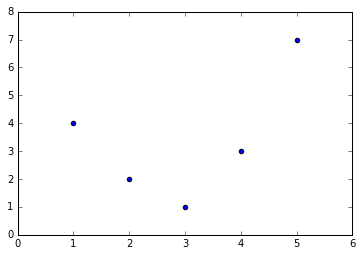

In [10]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

x = np.array([1, 2, 3, 4, 5])
y = np.array([4, 2, 1, 3, 7])
plt.scatter(x, y);

それでも、LinearRegression を使用してデータに線を当てはめ、最適な結果を得ることができます。

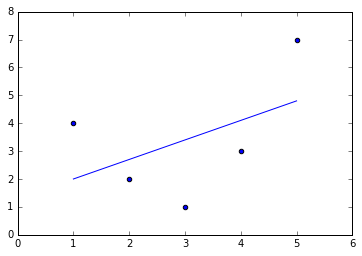

In [11]:
from sklearn.linear_model import LinearRegression
X = x[:, np.newaxis]
model = LinearRegression().fit(X, y)
yfit = model.predict(X)
plt.scatter(x, y)
plt.plot(x, yfit);

$x$ と $y$ の関係を記述するには、より洗練されたモデルが必要であることは明らかです。

これに対する 1 つのアプローチは、モデルの柔軟性を高めるために特徴の列を追加して、データを変換することです。
たとえば、次のようにしてデータに多項式機能を追加できます。

In [12]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=3, include_bias=False)
X2 = poly.fit_transform(X)
print(X2)

[[   1.    1.    1.]
 [   2.    4.    8.]
 [   3.    9.   27.]
 [   4.   16.   64.]
 [   5.   25.  125.]]


派生した特徴マトリックスには、$x$ を表す 1 つの列、$x^2$ を表す 2 番目の列、および $x^3$ を表す 3 番目の列があります。
この拡張された入力に対して線形回帰を計算すると、データにより近い適合が得られます。

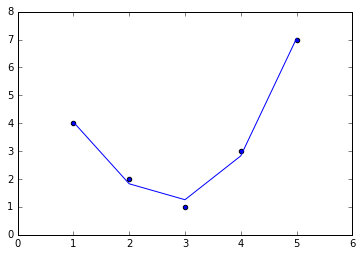

In [13]:
model = LinearRegression().fit(X2, y)
yfit = model.predict(X2)
plt.scatter(x, y)
plt.plot(x, yfit);

モデルを変更するのではなく、入力を変換することによってモデルを改善するというこの考え方は、より強力な機械学習手法の多くの基本となっています。
*基底関数回帰*のコンテキストで、[In Depth: Linear Regression](05.06-Linear-Regression.ipynb) でこのアイデアをさらに検討します。
より一般的に言えば、これは、[In-Depth: Support Vector Machines](05.07-Support-Vector-Machines.ipynb) で説明する、*カーネル メソッド*として知られる一連の強力な手法への動機付けとなる道の 1 つです。

## 欠損データの代入

機能エンジニアリングにおけるもう 1 つの一般的なニーズは、欠損データの処理です。
[Handling Missing Data](03.04-Missing-Values.ipynb) で ``DataFrame``s の欠損データの処理について説明し、欠損値をマークするために ``NaN`` 値がよく使用されることを確認しました。
たとえば、次のようなデータセットがあるとします。

In [14]:
from numpy import nan
X = np.array([[ nan, 0,   3  ],
              [ 3,   7,   9  ],
              [ 3,   5,   2  ],
              [ 4,   nan, 6  ],
              [ 8,   8,   1  ]])
y = np.array([14, 16, -1,  8, -5])

典型的な機械学習モデルをそのようなデータに適用する場合、まず、欠落しているデータを適切な値で置き換える必要があります。
これは欠損値の*代入*として知られており、戦略は単純なもの (例: 欠損値を列の平均値で置き換える) から複雑なもの (例: 行列補完や堅牢なモデルを使用してそのようなデータを処理する) までさまざまです。

洗練されたアプローチは、非常にアプリケーション固有である傾向があり、ここでは詳しく説明しません。
平均値、中央値、または最頻値を使用したベースライン補完アプローチのために、Scikit-Learn は ``Imputer`` クラスを提供します。

In [15]:
from sklearn.preprocessing import Imputer
imp = Imputer(strategy='mean')
X2 = imp.fit_transform(X)
X2

array([[ 4.5,  0. ,  3. ],
       [ 3. ,  7. ,  9. ],
       [ 3. ,  5. ,  2. ],
       [ 4. ,  5. ,  6. ],
       [ 8. ,  8. ,  1. ]])

結果のデータでは、2 つの欠損値が列の残りの値の平均に置き換えられていることがわかります。この帰属されたデータは、たとえば ``LinearRegression`` 推定器に直接供給することができます:

In [16]:
model = LinearRegression().fit(X2, y)
model.predict(X2)

array([ 13.14869292,  14.3784627 ,  -1.15539732,  10.96606197,  -5.33782027])

## 機能パイプライン

上記の例のいずれにおいても、特に複数のステップをつなぎ合わせたい場合は、手動で変換を行うのはすぐに面倒になる可能性があります。
たとえば、次のような処理パイプラインが必要な場合があります。

1. 平均を使用して欠損値を代入する
2.特徴を二次に変換する
3. 線形回帰を当てはめる

このタイプの処理パイプラインを合理化するために、Scikit-Learn は次のように使用できる ``Pipeline`` オブジェクトを提供します。

In [17]:
from sklearn.pipeline import make_pipeline

model = make_pipeline(Imputer(strategy='mean'),
                      PolynomialFeatures(degree=2),
                      LinearRegression())

このパイプラインは、標準の Scikit-Learn オブジェクトのように見え、機能し、指定されたすべてのステップを任意の入力データに適用します。

In [18]:
model.fit(X, y)  # X with missing values, from above
print(y)
print(model.predict(X))

[14 16 -1  8 -5]
[ 14.  16.  -1.   8.  -5.]


モデルのすべてのステップが自動的に適用されます。
このデモンストレーションを簡単にするために、トレーニングに使用したデータにモデルを適用したことに注意してください。これが、結果を完全に予測できた理由です (詳細については、[Hyperparameters and Model Validation](05.03-Hyperparameters-and-Model-Validation.ipynb) を参照してください)。

実際の Scikit-Learn パイプラインの例については、単純ベイズ分類に関する次のセクション、および [In Depth: Linear Regression](05.06-Linear-Regression.ipynb) と [In Depth: Linear Regression](05.06-Linear-Regression.ipynb) を参照してください。

<!--ナビゲーション-->
< [Hyperparameters and Model Validation](05.03-Hyperparameters-and-Model-Validation.ipynb) | [Hyperparameters and Model Validation](05.03-Hyperparameters-and-Model-Validation.ipynb) | [Hyperparameters and Model Validation](05.03-Hyperparameters-and-Model-Validation.ipynb) >

<a href="https://colab.research.google.com/github/vitroid/PythonDataScienceHandbook/blob/ja/notebooks/05.04-Feature-Engineering.ipynb"><img align="left" src="https: //colab.research.google.com/assets/colab-badge.svg" alt="Colab で開く" title="Google Colaboratory で開いて実行する"></a>
